In [ ]:
# !pip install lightgbm==3.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
import joblib

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD

In [ ]:
from utils import prepare_data, prepare_dataloader
from src import train_model, FCModel, CNNModel, LSTMModel

# Обработка данных

In [ ]:
data = pd.read_csv('../data/gazp.csv', sep=',') # загружаем данные
data.drop(labels=['<PER>', '<TIME>'], axis=1, inplace=True) # убираем из таблицы ненужные столбцы
data.rename({'<TICKER>': 'company', '<CLOSE>': 'close', '<DATE>': 'date'}, axis=1, inplace=True) # переименовываем оставшиеся столбцы
data['date'] = pd.to_datetime(data['date'], dayfirst=True) # приводим столбец с датами к нужному формату
data.set_index('date', inplace=True)
data.head()

,company,close
date,,
2010-01-11,GAZP,194.50
2010-01-12,GAZP,191.80
2010-01-13,GAZP,189.30
2010-01-14,GAZP,190.83
2010-01-15,GAZP,187.86


In [ ]:
min(data.index), max(data.index)

(Timestamp('2010-01-11 00:00:00'), Timestamp('2022-12-30 00:00:00'))

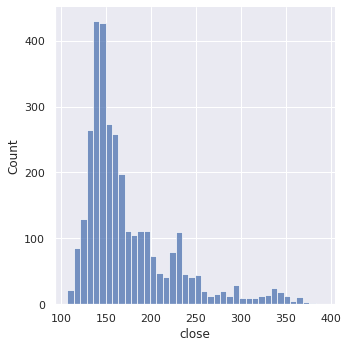

In [ ]:
sns.displot(data.close)

In [ ]:
data.describe()

,close
count,3250.000000
mean,174.658982
std,51.103808
min,107.230000
25%,140.627500
50%,156.495000
75%,193.857500
max,389.820000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3250 entries, 2010-01-11 to 2022-12-30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   company  3250 non-null   object 
 1   close    3250 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.2+ KB


<Figure size 1440x720 with 0 Axes>

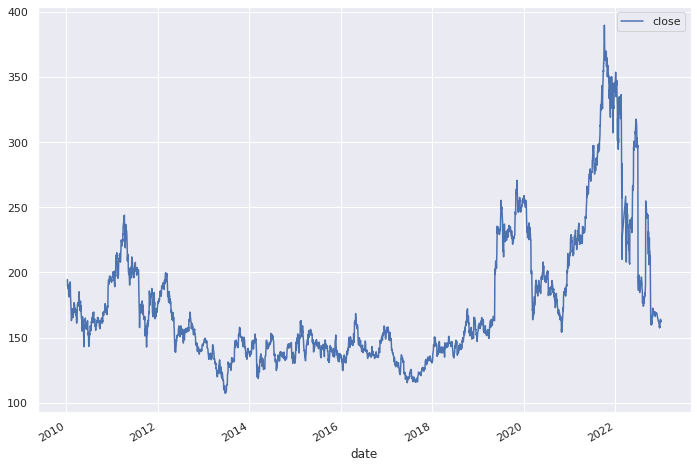

In [ ]:
fig = plt.figure(figsize=(20, 10))
#sns.set()
data.plot()
plt.show()

In [ ]:
# plt.plot(history['train'])
# plt.plot(history['val'])
# plt.legend(['train', 'val'])

In [ ]:
models = [LogisticRegression(solver='liblinear'), CatBoostClassifier(n_estimators=800), XGBClassifier(n_estimators=800), LGBMClassifier(n_estimators=800)]
windows = [7, 14, 30, 60, 90, 180]

In [ ]:
# model = LGBMClassifier(n_estimators=800)
# cropped_data = data.loc[data.index < '2018-02-01']
# X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification')
# model.fit(X_train, y_train)
# joblib.dump(model, 'model_aero.bin')
# model = joblib.load('model_aero.bin')
# y_pred = model.predict(X_test)
# print(f1_score(y_test, y_pred))

In [ ]:
dates = ['2019-02-01',
         '2019-03-01',
         '2019-04-01',
         '2019-05-01',
         '2019-06-01',
         '2019-07-01',
         '2019-08-01',
         '2019-09-01',
         '2019-10-01',
         '2019-11-01',
         '2019-12-01',
         '2020-01-01',]

In [ ]:
results = {
    'accuracy': {
      'XGBClassifier': [],
      'LogisticRegression': [],
      'CatBoostClassifier': [],
      'LGBMClassifier': [],
    },
    'f1_score': {
      'XGBClassifier': [],
      'LogisticRegression': [],
      'CatBoostClassifier': [],
      'LGBMClassifier': [],
    }
}

In [ ]:
for model in models:
  for win_size in tqdm(windows):
    f1_scores, acc_scores = [], []
    for date in dates:
      cropped_data = data.loc[data.index < date]
      X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification', win_size)
      model_temp = model
      model_temp.fit(X_train, y_train)
      test_preds = model_temp.predict(X_test)
      f1_scores.append(f1_score(y_test, test_preds))
      acc_scores.append(accuracy_score(y_test, test_preds))
    results['accuracy'][type(model_temp).__name__].append(sum(acc_scores) / len(acc_scores))
    results['f1_score'][type(model_temp).__name__].append(sum(f1_scores) / len(f1_scores))

In [ ]:
nn_models = ["FCModel", "LSTMModel"]

In [ ]:
nn_results = {
    'accuracy': {
      'FCModel': [],
      'CNNModel': [],
      'LSTMModel': [],
    },
    'f1_score': {
      'FCModel': [],
      'CNNModel': [],
      'LSTMModel': [],
    }
}

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_function = nn.BCEWithLogitsLoss()

In [ ]:
for model in nn_models:
  for win_size in tqdm(windows):
    f1_scores, acc_scores = [], []
    for date in dates:
      cropped_data = data.loc[data.index < date]
      X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification', win_size)
      train_dataloader, test_dataloader = prepare_dataloader(X_train, y_train, X_test, y_test)

      model_temp = globals()[model](win_size)
      model_temp = model_temp.to(device)
      optimizer = Adam(model_temp.parameters(), lr=0.0001)
      train_model(model_temp, loss_function, optimizer, 1000)

      test_preds = model_temp.infer(test_data)
      f1_scores.append(f1_score(test_target, test_preds.cpu()))
      acc_scores.append(accuracy_score(test_target, test_preds.cpu()))
    nn_results['accuracy'][type(model_temp).__name__].append(sum(acc_scores) / len(acc_scores))
    nn_results['f1_score'][type(model_temp).__name__].append(sum(f1_scores) / len(f1_scores))

100%|██████████| 6/6 [41:03<00:00, 410.63s/it]


In [ ]:
for win_size in tqdm(windows):
  f1_scores, acc_scores = [], []
  mean_acc, mean_f1 = np.nan, np.nan
  if win_size > 30:
    for date in dates:
      cropped_data = data.loc[data.index < date]
      X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification', win_size)
      train_dataloader, test_dataloader = prepare_dataloader(X_train, y_train, X_test, y_test)

      model_temp = CNNModel(win_size)
      model_temp = model_temp.to(device)
      optimizer = Adam(model_temp.parameters(), lr=0.0001)
      train_model(model_temp, loss_function, optimizer, 1000, cnn_flg=True)
      test_data = test_data[None, :]
      test_data = test_data.permute(1, 0, 2)
      test_preds = model_temp.infer(test_data)
      f1_scores.append(f1_score(test_target, test_preds.cpu()))
      acc_scores.append(accuracy_score(test_target, test_preds.cpu()))
    mean_acc, mean_f1 = sum(acc_scores) / len(acc_scores), sum(f1_scores) / len(f1_scores)
  nn_results['accuracy']['CNNModel'].append(mean_acc), 
  nn_results['f1_score']['CNNModel'].append(mean_f1)

100%|██████████| 6/6 [14:33<00:00, 145.59s/it]


In [ ]:
all_results = results
for key in nn_results.keys():
  for m_name in nn_results[key].keys():
    all_results[key][m_name] = nn_results[key][m_name]

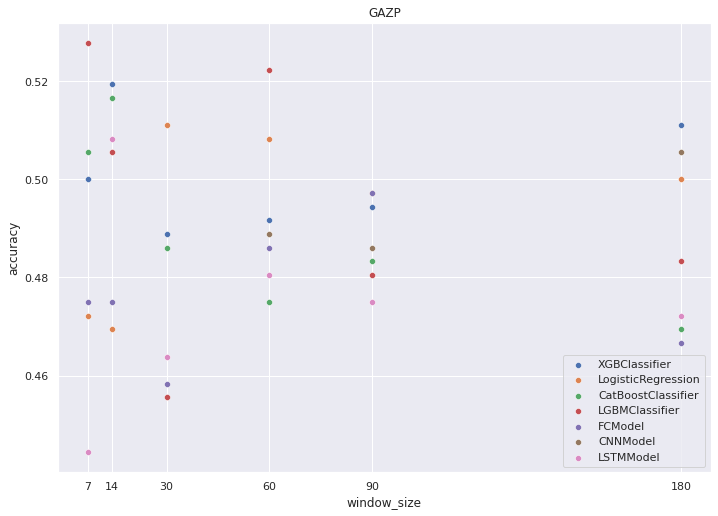

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
for name in all_results['accuracy'].keys():
  sns.scatterplot(x=windows, y=all_results['accuracy'][name], label=name)
plt.xticks(windows)
plt.ylabel('accuracy')
plt.xlabel('window_size')
plt.title('GAZP')
plt.show()

In [ ]:
pd.DataFrame(all_results).to_csv('gazp_models.csv')

In [ ]:
# def predict_model(model, train_data: pd.DataFrame):
#   y_pred = []
#   X_temp = np.array(train_data.close.values[-WINDOW_SIZE:], ndmin=2)
#   for i in range(WINDOW_SIZE):
#     temp_pred = model.predict(X_temp)
#     X_temp = np.append(X_temp[:, 1:], np.array(temp_pred, ndmin=2), axis=1)
#     y_pred.append(temp_pred[0])
#   return np.array(y_pred).reshape(-1, 1)
# y_pred = predict_model(model, train_data)

In [ ]:
# model.save_model('model.bin')
# model.load_model('model.bin')

<AxesSubplot:>

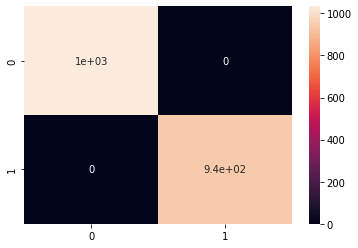

In [ ]:
train_preds = model.predict(X_train)
train_cm = confusion_matrix(y_train, train_preds)
sns.heatmap(train_cm, annot=True)

In [ ]:
(train_cm[0][0] + train_cm[1][1]) / train_cm.sum()

1.0

In [ ]:
y_preds = model.predict(X_test)

<AxesSubplot:>

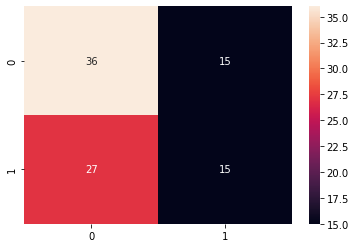

In [ ]:
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True)

In [ ]:
acc = (cm[0][0] + cm[1][1]) / cm.sum()
acc

0.5483870967741935